# Modeling with particle swarm optimization feature selection (next year)

## Install packages

In [1]:
# Setting current working directory
import os
path = "/Users/fleurroijen/Library/Mobile Documents/com~apple~CloudDocs/Documents/University/Tilburg University MSc/TiU Spring 24:25/Master Thesis : Data Science in Action/Predicting-Tax-Avoidance"
os.chdir(path)

In [2]:
# Loading necessary packages
import datetime
import warnings
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Visualization
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from pandas.plotting import register_matplotlib_converters

# Optimization
import optuna
from optuna import Trial, visualization

# Scikit-learn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score
)

# XGBoost
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Loading the datasets
X_train_full = pd.read_csv('X_train_full.csv', index_col=0)
X_train = pd.read_csv('X_train.csv', index_col=0)
X_val = pd.read_csv('X_val.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_train_full = pd.read_csv('y_train_full.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_val = pd.read_csv('y_val.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [4]:
# Checking the datasets
print(X_train_full.shape)
print(y_train_full.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(43522, 77)
(43522, 1)
(34818, 77)
(34818, 1)
(8704, 77)
(8704, 1)
(7445, 77)
(7445, 1)


In [5]:
if isinstance(y_train_full, pd.DataFrame) and y_train_full.shape[1] == 1:
    y_train_full = y_train_full.squeeze()

In [6]:
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
    y_train = y_train.squeeze()
y_train = np.asarray(y_train)

In [7]:
if not isinstance(y_train_full, pd.Series):
    y_train_full = pd.Series(y_train_full, name="tax_avoidance_ind")

In [8]:
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train, name="tax_avoidance_ind")

## Feature selection with particle swarm optimization

In [9]:
# Code inspired by:
# https://github.com/Anas1108/Particle-_Swarm_Optimization-PSO-_for_Feature_Selection

In [ ]:
# Generating the initial population
def generate_initial_particles(pop_size, num_features, min_features, max_features, fyear_sin_index, fyear_cos_index):
    particles = np.zeros((pop_size, num_features))
    for i in range(pop_size):
        num_ones = np.random.randint(min_features, max_features + 1)
        ones_indices = np.random.choice(num_features, num_ones, replace=False)
        particles[i, ones_indices] = 1

        if particles[i, fyear_sin_index] == 1:
            particles[i, fyear_cos_index] = 1
        if particles[i, fyear_cos_index] == 1:
            particles[i, fyear_sin_index] = 1

    return particles

In [11]:
# Initializing the particles
def initialize_particles(pop_size, num_features, min_features, max_features):
    particles = generate_initial_particles(pop_size, num_features, min_features, max_features)
    velocities = np.random.uniform(-1, 1, particles.shape)
    return particles, velocities

In [12]:
# Training the model with random forest
def train_model(X_train, X_val, y_train, y_val, feature_names):
    X_train = X_train.loc[:, feature_names]
    X_val = X_val.loc[:, feature_names]
    mdl = RandomForestClassifier(random_state=123)
    mdl.fit(X_train, y_train)
    y_hat = mdl.predict(X_val)
    precision = precision_score(y_val, y_hat)
    return precision

In [13]:
# Evaluating fitness
def evaluate_fitness(particles, X_train, X_val, y_train, y_val, feature_names, n_jobs=-1):
    def evaluate_single(i):
        selected_features = feature_names[particles[i, :] == 1]
        return train_model(X_train, X_val, y_train, y_val, selected_features)

    fitness = Parallel(n_jobs=n_jobs)(delayed(evaluate_single)(i) for i in range(particles.shape[0]))
    return np.array(fitness)

In [14]:
# Defining sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# Updating the particles
def update_velocity_position(particles, velocities, pbest, gbest, inertia_weight, cognitive_coeff, social_coeff, fyear_sin_index, fyear_cos_index):
    r1 = np.random.rand(*particles.shape)
    r2 = np.random.rand(*particles.shape)

    velocities = (inertia_weight * velocities +
                  cognitive_coeff * r1 * (pbest - particles) +
                  social_coeff * r2 * (gbest - particles))
    
    sigmoid = 1 / (1 + np.exp(-velocities))
    new_particles = np.where(sigmoid > 0.5, 1, 0)

    for i in range(new_particles.shape[0]):
        if new_particles[i, fyear_sin_index] == 1:
            new_particles[i, fyear_cos_index] = 1
        if new_particles[i, fyear_cos_index] == 1:
            new_particles[i, fyear_sin_index] = 1

    return new_particles, velocities

In [ ]:
# Enforcing feature bounds
def enforce_feature_bounds(particles, min_features, max_features, fyear_sin_index, fyear_cos_index):
    for i in range(particles.shape[0]):
        num_selected = np.sum(particles[i])
        if num_selected > max_features:
            excess = int(num_selected - max_features)
            ones_idx = np.where(particles[i]==1)[0]
            turn_off = np.random.choice(ones_idx, size=excess, replace=False)
            particles[i, turn_off] = 0
        elif num_selected < min_features:
            missing = int(min_features - num_selected)
            zeros_idx = np.where(particles[i]==0)[0]
            turn_on = np.random.choice(zeros_idx, size=missing, replace=False)
            particles[i, turn_on] = 1

        if particles[i, fyear_sin_index] == 1:
            particles[i, fyear_cos_index] = 1
        if particles[i, fyear_cos_index] == 1:
            particles[i, fyear_sin_index] = 1

    return particles

In [ ]:
# Setting hyperparameters
min_features = 2
max_features = 37
pop_size = 20
max_iterations = 20
inertia_weight = 0.7
cognitive_coeff = 1.5
social_coeff = 1.5

num_features = X_train.shape[1]
feature_names = X_train.columns
fyear_sin_index = feature_names.get_loc('fyear_sin')
fyear_cos_index = feature_names.get_loc('fyear_cos')
early_stopping_rounds = 10

In [ ]:
# PSO initializing generation 0
particles, velocities = initialize_particles(pop_size, num_features, min_features, max_features, fyear_sin_index, fyear_cos_index)
fitness = evaluate_fitness(particles, X_train, X_val, y_train, y_val, feature_names, n_jobs=-1)
pbest = particles.copy()
pbest_fitness = fitness.copy()
gbest_index = np.argmax(fitness)
gbest = particles[gbest_index].copy()
gbest_fitness = fitness[gbest_index]

# Tracking the best accuracy in each generation for early stopping
best_acc_i = np.zeros(max_iterations)
best_acc_i[0] = gbest_fitness
no_improvement_count = 0
best_acc = gbest_fitness

# PSO main loop
for gen in range(1, max_iterations):
    print(f'Begin iteration num {gen + 1}/{max_iterations}')
    gen += 1
    
    # Updating velocity and position
    particles, velocities = update_velocity_position(particles, velocities, pbest, gbest, inertia_weight, cognitive_coeff, social_coeff, fyear_sin_index, fyear_cos_index)
    fitness = evaluate_fitness(particles, X_train, X_val, y_train, y_val, feature_names, n_jobs=-1)
    particles = enforce_feature_bounds(particles, min_features, max_features, fyear_sin_index, fyear_cos_index)
        
    # Updating personal best and global best
    for i in range(pop_size):
        if fitness[i] > pbest_fitness[i]:
            pbest[i] = particles[i].copy()
            pbest_fitness[i] = fitness[i]
            
            # Updating global best
            if fitness[i] > gbest_fitness:
                gbest = particles[i].copy()
                gbest_fitness = fitness[i]
    
    # Tracking best accuracy
    best_acc_i[gen] = gbest_fitness
    
    # Early stopping check
    if best_acc_i[gen] > best_acc:
        best_acc = best_acc_i[gen]
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        print(f"No improvement for {no_improvement_count} generations.")

    if no_improvement_count >= early_stopping_rounds:
        print(f"Early stopping triggered at generation {gen + 1}.")
        break

# Summarizing the results
best_features = gbest
print("Best features selected (indices):", np.where(best_features == 1)[0])
print("Best accuracy achieved:", best_acc)

Begin iteration num 2/20
Begin iteration num 3/20
Begin iteration num 4/20
No improvement for 1 generations.
Begin iteration num 5/20
No improvement for 2 generations.
Begin iteration num 6/20
No improvement for 3 generations.
Begin iteration num 7/20
No improvement for 4 generations.
Begin iteration num 8/20
No improvement for 5 generations.
Begin iteration num 9/20
No improvement for 6 generations.
Begin iteration num 10/20
No improvement for 7 generations.
Begin iteration num 11/20
No improvement for 8 generations.
Begin iteration num 12/20
Begin iteration num 13/20
Begin iteration num 14/20
No improvement for 1 generations.
Begin iteration num 15/20
No improvement for 2 generations.
Begin iteration num 16/20
No improvement for 3 generations.
Begin iteration num 17/20
No improvement for 4 generations.
Begin iteration num 18/20
Begin iteration num 19/20
No improvement for 1 generations.
Begin iteration num 20/20
No improvement for 2 generations.
Best features selected (indices): [ 1 

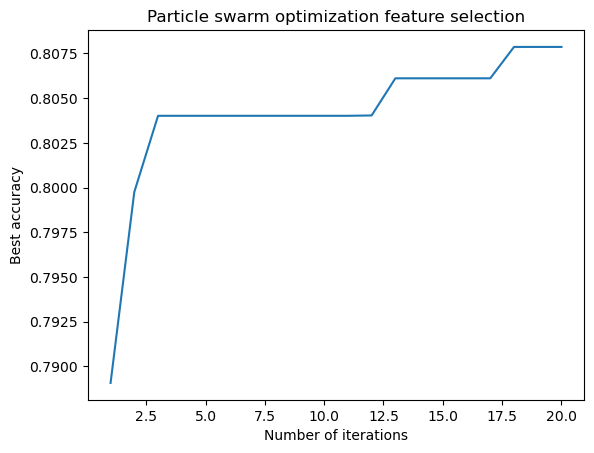

In [19]:
# Plotting the results
plt.plot(range(1, max_iterations+1), best_acc_i)
plt.xlabel('Number of iterations')
plt.ylabel('Best accuracy')
plt.title('Particle swarm optimization feature selection')
plt.show()

In [20]:
# Creating new dataset with selected features
best_features_names = feature_names[best_features == 1]
X_train_PSO_full = X_train_full[best_features_names]
X_train_PSO = X_train[best_features_names]
X_val_PSO = X_val[best_features_names]
X_test_PSO = X_test[best_features_names]

# Displaying the results
print("Selected features from PSO:", list(best_features_names))
print("Shape of reduced full training data (X_train_PSO_full):", X_train_PSO_full.shape)
print("Shape of reduced training data (X_train_PSO):", X_train_PSO.shape)
print("Shape of reduced validation data (X_val_PSO):", X_val_PSO.shape)
print("Shape of reduced test data (X_test_PSO):", X_test_PSO.shape)

Selected features from PSO: ['ao_lag1', 'apo_lag1', 'capx_lag1', 'ceq_lag1', 'cogs_lag1', 'dltt_lag1', 'fca_lag1', 'gdwl_lag1', 'intan_lag1', 'lco_lag1', 'lct_lag1', 'lo_lag1', 'lt_lag1', 'oancf_lag1', 'oiadp_lag1', 'revt_lag1', 'txc_lag1', 'txdb_lag1', 'txditc_lag1', 'txo_lag1', 'txp_lag1', 'wcapopc_lag1', 'xacc_lag1', 'xopr_lag1', 'xpp_lag1', 'xsga_lag1', 'etr_lag1', 'region_East', 'region_North', 'industry_Agriculture', 'industry_Industrial', 'industry_Nonclassifiable', 'industry_Services', 'industry_Social', 'industry_Trade', 'fyear_sin', 'fyear_cos']
Shape of reduced full training data (X_train_PSO_full): (43522, 37)
Shape of reduced training data (X_train_PSO): (34818, 37)
Shape of reduced validation data (X_val_PSO): (8704, 37)
Shape of reduced test data (X_test_PSO): (7445, 37)


## Modeling

### Baseline logistic regression (no hyperparameter tuning)

In [21]:
# Instantiating the classifier 
model_lr = LogisticRegression(random_state=123)

# Fitting the model
model_lr.fit(X_train_PSO_full, y_train_full)

LogisticRegression(random_state=123)

In [22]:
# Making predictions (test set)
y_pred_lr = model_lr.predict(X_test_PSO)
y_proba_lr = model_lr.predict_proba(X_test_PSO)
y_proba_lr_pos = y_proba_lr[:, 1]

In [23]:
# Making predictions (train set)
y_pred_lr_train = model_lr.predict(X_train_PSO_full)
y_proba_lr_train = model_lr.predict_proba(X_train_PSO_full)
y_proba_lr_train_pos = y_proba_lr_train[:, 1]

#### Evaluating baseline logistic regression

In [24]:
# Creating a function for the evaluation metrics
def evaluate(y_true, y_pred, y_proba, classifier):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"Evaluation metrics for {classifier}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

In [25]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_lr, y_proba_lr_pos, "baseline logistic regression with PSO feature selection")

Evaluation metrics for baseline logistic regression with PSO feature selection:
Accuracy: 0.6402
Precision: 0.4092
Recall: 0.7571
F1 Score: 0.5312
AUC-ROC: 0.7316
Precision-Recall AUC: 0.4556


In [26]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_lr_train, y_proba_lr_train_pos, "baseline logistic regression with PSO feature selection (train set)")

Evaluation metrics for baseline logistic regression with PSO feature selection (train set):
Accuracy: 0.6777
Precision: 0.6531
Recall: 0.7582
F1 Score: 0.7017
AUC-ROC: 0.7372
Precision-Recall AUC: 0.6984


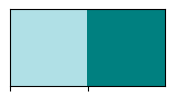

In [27]:
# Defining a smooth fading color gradient
color_codes = ["powderblue", "teal"]
fading_cmap = LinearSegmentedColormap.from_list("fading_blues", color_codes)

# Displaying the fading color palette (optional)
sns.palplot(sns.color_palette(color_codes))

In [28]:
# Code inspired by:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
def plot_confusion_matrix(y_true, y_pred, model_name):
    class_names = ['yes', 'no']

    # Computing and normalizing the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(matrix, annot=True, fmt=".2f", cmap=fading_cmap, 
                     xticklabels=class_names, yticklabels=class_names,
                     linewidths=0.2, vmin=0, vmax=1)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.tight_layout()
    plt.show()

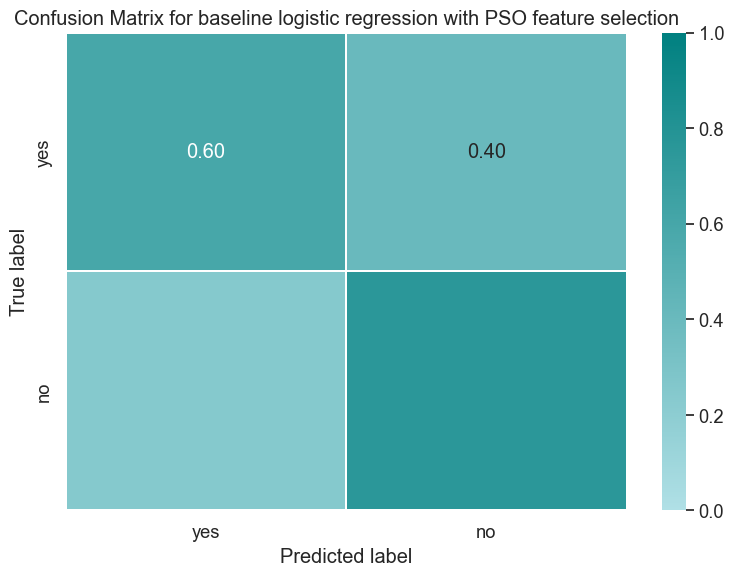

In [29]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr, "baseline logistic regression with PSO feature selection")

In [30]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      5440
           1       0.41      0.76      0.53      2005

    accuracy                           0.64      7445
   macro avg       0.64      0.68      0.62      7445
weighted avg       0.75      0.64      0.66      7445



### Logistic regression

In [31]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67

# Defining an objective function to be maximized using pre-defined train/val splits
def objective_lr(trial):
    # Define all valid (solver, penalty) combos explicitly
    solver_penalty_combo = trial.suggest_categorical(
        'solver_penalty',
        [
            ('lbfgs', 'l2'),               # lbfgs only supports l2
            ('liblinear', 'l1'),
            ('liblinear', 'l2'),
            ('saga', 'l1'),
            ('saga', 'l2'),
            ('saga', 'elasticnet'),
        ]
    )
    
    solver, penalty = solver_penalty_combo
    
    C = trial.suggest_float("C", 1e-4, 1e4, log=True)
    tol = trial.suggest_float("tol", 1e-4, 1e-1, log=True)
    verbose = trial.suggest_int("verbose", 0, 1)
    
    params_lr = dict(solver=solver, penalty=penalty, C=C, tol=tol, verbose=verbose)
    
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        params_lr["l1_ratio"] = l1_ratio
    
    model_lr = LogisticRegression(**params_lr, random_state=123, n_jobs=-1)
    
    model_lr.fit(X_train_PSO, y_train)
    
    y_pred = model_lr.predict(X_val_PSO)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_lr.trials))
print('Best parameters:', study_lr.best_trial.params)
print('Best F1 score:', study_lr.best_value)

[I 2025-05-16 19:53:19,326] A new study created in memory with name: no-name-4b585d46-c99c-4d0d-9c39-f674c7a59dd2


[LibLinear]RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds
Epoch 1, change: 1

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'elasticnet') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, in

Epoch 2, change: 0.42409043
Epoch 3, change: 0.26688724

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     22     24      1     0     0   8.197D-04   6.068D-01
  F =  0.60680506570234749     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 4, change: 0.19890245
Epoch 5, change: 0.15931188
Epoch 6, change: 0.13373655


[I 2025-05-16 19:53:19,619] Trial 5 finished with value: 0.6935398323963085 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 69.41117957586583, 'tol': 0.05658080524945294, 'verbose': 0}. Best is trial 5 with value: 0.6935398323963085.
[I 2025-05-16 19:53:19,631] Trial 7 finished with value: 0.6934662706830717 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 20.687213214217042, 'tol': 0.06153122450464712, 'verbose': 1}. Best is trial 5 with value: 0.6935398323963085.


Epoch 7, change: 0.11553899
[LibLinear]Epoch 8, change: 0.10170108
Epoch 1, change: 1
Epoch 1, change: 1
iter   1  #CD cycles 1
Epoch 9, change: 0.09060617
iter   2  #CD cycles 1
Epoch 2, change: 0.42408774
iter   3  #CD cycles 2
Epoch 2, change: 0.42409066
iter   4  #CD cycles 1
Epoch 3, change: 0.26688381


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 4, change: 0.19889879
Epoch 3, change: 0.26688753
Epoch 5, change: 0.15930813
iter   5  #CD cycles 5
Epoch 10, change: 0.081568197
iter   6  #CD cycles 1
Epoch 6, change: 0.13373278
Epoch 4, change: 0.19890276
Epoch 11, change: 0.074026519
Epoch 12, change: 0.067731945
Epoch 7, change: 0.11553522
Epoch 5, change: 0.15931221
Epoch 8, change: 0.10169731
Epoch 6, change: 0.13373688
Epoch 9, change: 0.090602412
Epoch 13, change: 0.062323912
Epoch 14, change: 0.05765233
Epoch 10, change: 0.081564443
Epoch 7, change: 0.11553932
Epoch 15, change: 0.053581516
Epoch 16, change: 0.049997854
Epoch 8, change: 0.10170141
iter   7  #CD cycles 28
Epoch 11, change: 0.074022774
iter   8  #CD cycles 4
Epoch 17, change: 0.046835972
iter   9  #CD cycles 1
Epoch 9, change: 0.090606494
Epoch 18, change: 0.044043083
Epoch 12, change: 0.067728205
Epoch 10, change: 0.081568521
Epoch 19, change: 0.041478108
Epoch 13, change: 0.062320179
Epoch 20, change: 0.039192025
Epoch 11, change: 0.074026843
Epoch 21,

[I 2025-05-16 19:53:20,281] Trial 9 finished with value: 0.691636518408172 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 0.6129147951305498, 'tol': 0.000320469645820857, 'verbose': 1}. Best is trial 5 with value: 0.6935398323963085.


Epoch 30, change: 0.024816656
Epoch 22, change: 0.035261834
Epoch 36, change: 0.020139322
[LibLinear]Epoch 37, change: 0.019512262
Epoch 31, change: 0.023905809
Epoch 23, change: 0.033543334
Epoch 38, change: 0.018915546
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 2
iter   4  #CD cycles 1
Epoch 32, change: 0.02304433


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 24, change: 0.031979742
Epoch 39, change: 0.018364282
Epoch 33, change: 0.022248054
iter   5  #CD cycles 6
Epoch 40, change: 0.017833158
Epoch 25, change: 0.030535005
iter   6  #CD cycles 1
Epoch 41, change: 0.017339271
Epoch 34, change: 0.021494897
Epoch 42, change: 0.016857295
Epoch 26, change: 0.029212154
Epoch 35, change: 0.020798446


[I 2025-05-16 19:53:20,575] Trial 4 finished with value: 0.6967366451881106 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 4375.924406088003, 'tol': 0.00622088550004469, 'verbose': 0}. Best is trial 4 with value: 0.6967366451881106.


Epoch 43, change: 0.016411292
Epoch 36, change: 0.020135743
Epoch 44, change: 0.015983928
Epoch 27, change: 0.027990645
Epoch 45, change: 0.015582173
iter   7  #CD cycles 20
Epoch 37, change: 0.019508686
Epoch 28, change: 0.026850999
Epoch 46, change: 0.015191766
iter   8  #CD cycles 4
Epoch 38, change: 0.018911976
iter   9  #CD cycles 1
Epoch 29, change: 0.025797469


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 47, change: 0.014825211
[LibLinear]Epoch 39, change: 0.018360717
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 2
iter   4  #CD cycles 1
Epoch 48, change: 0.014472765
Epoch 30, change: 0.024820582
iter   5  #CD cycles 9
Epoch 40, change: 0.017829597
Epoch 49, change: 0.01413384
iter   6  #CD cycles 1


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 31, change: 0.023909728
Epoch 41, change: 0.017335715
Epoch 1, change: 1
Epoch 50, change: 0.013812775
Epoch 42, change: 0.016853743
Epoch 2, change: 0.42409065
Epoch 3, change: 0.26688752
Epoch 32, change: 0.023048244
Epoch 4, change: 0.19890275
Epoch 51, change: 0.013506749
iter  10  #CD cycles 26
Epoch 5, change: 0.1593122
Epoch 43, change: 0.016407744
Epoch 6, change: 0.13373687
iter   7  #CD cycles 26
Epoch 33, change: 0.02225196
Epoch 52, change: 0.013213197
Epoch 44, change: 0.015980384
iter  11  #CD cycles 5
Epoch 7, change: 0.11553932
iter  12  #CD cycles 1
iter   8  #CD cycles 3
iter   9  #CD cycles 2
Epoch 53, change: 0.012932647
Epoch 45, change: 0.015578633
iter  10  #CD cycles 1
Epoch 8, change: 0.10170141
Epoch 46, change: 0.015188229
Epoch 34, change: 0.021498799
Epoch 54, change: 0.012661664
Epoch 55, change: 0.012403677
Epoch 9, change: 0.090606493
Epoch 47, change: 0.014821678
Epoch 35, change: 0.020802342
Epoch 48, change: 0.014469235
Epoch 56, change: 0.01215

[I 2025-05-16 19:53:21,183] Trial 11 finished with value: 0.692414086604958 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 162.18430551781128, 'tol': 0.0009620886812129635, 'verbose': 1}. Best is trial 4 with value: 0.6967366451881106.


Epoch 41, change: 0.017339579
iter  13  #CD cycles 63
Epoch 55, change: 0.012400168
Epoch 63, change: 0.010662444
Epoch 16, change: 0.049998175
iter  14  #CD cycles 5
optimization finished, #iter = 14
Objective value = 3424593.472337
#nonzeros/#features = 38/38
Epoch 42, change: 0.016857603
Epoch 56, change: 0.012150543
Epoch 64, change: 0.010477089
Epoch 17, change: 0.046836292
Epoch 65, change: 0.010303075
Epoch 57, change: 0.01191465
Epoch 43, change: 0.0164116
Epoch 18, change: 0.044043403
Epoch 66, change: 0.010130969
Epoch 58, change: 0.01168081
Epoch 44, change: 0.015984235
Epoch 19, change: 0.041478428
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauch

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 45, change: 0.01558248
Epoch 60, change: 0.011249575
Epoch 68, change: 0.0098061989
Epoch 20, change: 0.039192344
Epoch 69, change: 0.0096519198
Epoch 46, change: 0.015192073
Epoch 61, change: 0.01104537
Epoch 21, change: 0.037122063
Epoch 47, change: 0.014825517
Epoch 62, change: 0.010847644
Epoch 70, change: 0.0095023797
Epoch 71, change: 0.0093573759
Epoch 63, change: 0.010658951
Epoch 22, change: 0.035261835
Epoch 48, change: 0.01447307
Epoch 72, change: 0.0092188221
Epoch 64, change: 0.010473597
Epoch 23, change: 0.033543334
Epoch 73, change: 0.0090846874
Epoch 65, change: 0.010299585
Epoch 49, change: 0.014134146
Epoch 66, change: 0.01012748
Epoch 24, change: 0.031979743
Epoch 74, change: 0.0089527164
Epoch 50, change: 0.01381308
Epoch 75, change: 0.0088256487
Epoch 25, change: 0.030535005
Epoch 67, change: 0.0099614273
Epoch 76, change: 0.0087018893
Epoch 51, change: 0.013507054
Epoch 68, change: 0.0098027124
Epoch 26, change: 0.029212155
Epoch 77, change: 0.0085827501
Epo

[I 2025-05-16 19:53:21,935] Trial 12 finished with value: 0.6919804296958094 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 1.6663525839811058, 'tol': 0.00023825508052956464, 'verbose': 1}. Best is trial 4 with value: 0.6967366451881106.


Epoch 80, change: 0.0082405729
Epoch 61, change: 0.01104917
Epoch 92, change: 0.0071394636
Epoch 81, change: 0.0081342328
Epoch 37, change: 0.019512572
Epoch 62, change: 0.010851441
Epoch 93, change: 0.0070624257
Epoch 82, change: 0.0080311405
Epoch 38, change: 0.018915856
Epoch 94, change: 0.0069861675
Epoch 63, change: 0.010662747
Epoch 83, change: 0.0079301015
iter  17  #CD cycles 89
Epoch 95, change: 0.0069126156
optimization finished, #iter = 17
Objective value = 35195.690035
#nonzeros/#features = 36/38
Epoch 39, change: 0.018364591
Epoch 64, change: 0.010477391
Epoch 84, change: 0.0078320714
Epoch 96, change: 0.0068397786
Epoch 65, change: 0.010303378
Epoch 40, change: 0.017833467
Epoch 97, change: 0.0067697118
Epoch 85, change: 0.0077365494
Epoch 66, change: 0.010131272
Epoch 67, change: 0.0099652166
Epoch 86, change: 0.0076446054
Epoch 98, change: 0.0067008919
Epoch 41, change: 0.01733958
Epoch 87, change: 0.0075542118


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 42, change: 0.016857603
Epoch 88, change: 0.0074668432
Epoch 99, change: 0.0066338006
Epoch 43, change: 0.0164116
Epoch 89, change: 0.0073790238
max_iter reached after 3 seconds
Epoch 100, change: 0.006568109
Epoch 68, change: 0.0098065009
Epoch 90, change: 0.0072966276
Epoch 44, change: 0.015984235
Epoch 69, change: 0.0096522217
Epoch 91, change: 0.0072153121
Epoch 45, change: 0.01558248
Epoch 70, change: 0.0095026815


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 92, change: 0.0071359821
Epoch 46, change: 0.015192073
Epoch 93, change: 0.0070589436


[I 2025-05-16 19:53:22,398] Trial 14 finished with value: 0.6444715943799634 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.05704821398366319, 'tol': 0.07684867448729765, 'verbose': 1}. Best is trial 4 with value: 0.6967366451881106.


Epoch 71, change: 0.0093576776
Epoch 94, change: 0.0069826848
Epoch 47, change: 0.014825517
Epoch 72, change: 0.0092191238
Epoch 95, change: 0.0069091322
Epoch 73, change: 0.009084989
Epoch 48, change: 0.014473071
Epoch 96, change: 0.0068362945
Epoch 97, change: 0.006766227
Epoch 49, change: 0.014134146
Epoch 74, change: 0.008953018
Epoch 98, change: 0.0066974063
Epoch 75, change: 0.0088259502
Epoch 50, change: 0.013813081
Epoch 76, change: 0.0087021908
Epoch 99, change: 0.0066303141


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

max_iter reached after 3 secondsEpoch 100, change: 0.0065646214

Epoch 51, change: 0.013507054
Epoch 52, change: 0.013213502
Epoch 77, change: 0.0085830516
Epoch 78, change: 0.0084662361
Epoch 53, change: 0.012932952
Epoch 54, change: 0.012661969
Epoch 79, change: 0.0083535166
Epoch 55, change: 0.012403981
Epoch 80, change: 0.0082443529
Epoch 56, change: 0.012154353
Epoch 81, change: 0.0081380128
Epoch 57, change: 0.011918458
Epoch 82, change: 0.0080349207
Epoch 83, change: 0.0079338815
Epoch 58, change: 0.011684617
Epoch 84, change: 0.0078358513
Epoch 59, change: 0.011466507
Epoch 85, change: 0.0077403293
Epoch 60, change: 0.011253376
Epoch 86, change: 0.007648386
Epoch 61, change: 0.011049171
Epoch 87, change: 0.0075579925
Epoch 62, change: 0.010851442
Epoch 88, change: 0.0074706245
Epoch 63, change: 0.010662747
Epoch 89, change: 0.007382805
Epoch 64, change: 0.010477392
Epoch 90, change: 0.0073004093
Epoch 65, change: 0.010303378
Epoch 66, change: 0.010131272
Epoch 91, change: 0.007

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 19:53:23,077] Trial 6 finished with value: 0.6535787321063394 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 4546.908134875767, 'tol': 0.0007763111841893712, 'verbose': 0}. Best is trial 4 with value: 0.6967366451881106.


Epoch 96, change: 0.0068400804
Epoch 71, change: 0.0093576779
Epoch 72, change: 0.0092191241
Epoch 97, change: 0.0067700137
Epoch 98, change: 0.0067011939
Epoch 73, change: 0.0090849893


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 99, change: 0.0066341026
Epoch 74, change: 0.0089530182
max_iter reached after 4 seconds
Epoch 100, change: 0.0065684112
Epoch 75, change: 0.0088259505


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 76, change: 0.0087021911
Epoch 77, change: 0.0085830519
Epoch 78, change: 0.0084662364
Epoch 79, change: 0.0083535169
Epoch 80, change: 0.0082443531
Epoch 81, change: 0.0081380131
Epoch 82, change: 0.0080349209
Epoch 83, change: 0.0079338818
Epoch 84, change: 0.0078358516
Epoch 85, change: 0.0077403296
Epoch 86, change: 0.0076483863


[I 2025-05-16 19:53:24,170] Trial 18 finished with value: 0.6474496575692528 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 2146.156117475921, 'tol': 0.015695807639078765, 'verbose': 0}. Best is trial 4 with value: 0.6967366451881106.


Epoch 87, change: 0.0075579928
Epoch 88, change: 0.0074706247
Epoch 89, change: 0.0073828052
Epoch 90, change: 0.0073004096
Epoch 91, change: 0.0072190949
Epoch 92, change: 0.0071397655
Epoch 93, change: 0.0070627276


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 94, change: 0.0069864694
Epoch 95, change: 0.0069129176
Epoch 96, change: 0.0068400807
Epoch 97, change: 0.0067700139


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[I 2025-05-16 19:53:24,484] Trial 23 finished with value: 0.6956071280563614 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.009763743362771391, 'tol': 0.00788230430658793, 'verbose': 0}. Best is trial 4 with value: 0.6967366451881106.
[I 2025-05-16 19:53:24,485] Trial 13 finished with value: 0.6535787321063394 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 660.1611536648659, 'tol': 0.00021054342786216033, 'verbose': 1}. Best is trial 4 with value: 0.6967366451881106.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  wa

Epoch 98, change: 0.0067011942
Epoch 99, change: 0.0066341029
max_iter reached after 4 seconds
Epoch 100, change: 0.0065684114


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

[LibLinear]iter   3  #CD cycles 2
iter   3  #CD cycles 2
iter   4  #CD cycles 2
iter   4  #CD cycles 1
iter   5  #CD cycles 2
iter   6  #CD cycles 1
iter   7  #CD cycles 23
iter   1  #CD cycles 1
iter   5  #CD cycles 6
iter   2  #CD cycles 1
iter   7  #CD cycles 5
iter   8  #CD cycles 5
iter   8  #CD cycles 2
iter   8  #CD cycles 22
iter   9  #CD cycles 2
iter   9  #CD cycles 2
iter   3  #CD cycles 4
iter  10  #CD cycles 1
iter   9  #CD cycles 1
iter   4  #CD cycles 1
iter   6  #CD cycles 7
iter   6  #CD cycles 25
iter  10  #CD cycles 3
iter   7  #CD cycles 4
iter   5  #CD cycles 4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 19:53:30,166] Trial 47 finished with value: 0.6535787321063394 and parameters: {'solver_penalty': ('saga', 'l2'), 'C': 1026.872993517608, 'tol': 0.0017408384417124004, 'verbose': 0}. Best is trial 29 with value: 0.6990431114312172.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choi

Epoch 1, change: 1
Epoch 2, change: 0.42409066
Epoch 3, change: 0.26688753
Epoch 4, change: 0.19890276
Epoch 5, change: 0.15931221
Epoch 6, change: 0.13373688
Epoch 7, change: 0.11553932


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 8, change: 0.10170141
Epoch 9, change: 0.090606495
Epoch 10, change: 0.081568521
Epoch 11, change: 0.074026843
Epoch 1, change: 1
Epoch 2, change: 0.42409066
Epoch 3, change: 0.26688753
Epoch 12, change: 0.067732268
Epoch 4, change: 0.19890276
Epoch 5, change: 0.15931221
Epoch 13, change: 0.062324235
Epoch 6, change: 0.13373688
Epoch 14, change: 0.057652652
Epoch 7, change: 0.11553932
Epoch 8, change: 0.10170141
Epoch 15, change: 0.053581837
Epoch 9, change: 0.090606495
Epoch 16, change: 0.049998175
Epoch 10, change: 0.081568521
Epoch 17, change: 0.046836292


[I 2025-05-16 19:53:31,236] Trial 59 finished with value: 0.6936391632154614 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 4265.431042958728, 'tol': 0.0038915015771705972, 'verbose': 0}. Best is trial 29 with value: 0.6990431114312172.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persiste

Epoch 11, change: 0.074026843
Epoch 18, change: 0.044043403
Epoch 19, change: 0.041478427
Epoch 12, change: 0.067732268
Epoch 13, change: 0.062324235
Epoch 20, change: 0.039192344
Epoch 1, change: 1
Epoch 2, change: 0.42409066
Epoch 14, change: 0.057652652
Epoch 21, change: 0.037122062
Epoch 3, change: 0.26688753
Epoch 4, change: 0.19890276


[I 2025-05-16 19:53:31,483] Trial 60 finished with value: 0.6967366451881106 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 9624.96490298615, 'tol': 0.013431064310694971, 'verbose': 0}. Best is trial 29 with value: 0.6990431114312172.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent sto

Epoch 15, change: 0.053581837
Epoch 5, change: 0.15931221
Epoch 22, change: 0.035261834
Epoch 6, change: 0.13373688
Epoch 16, change: 0.049998175
Epoch 23, change: 0.033543334
Epoch 7, change: 0.11553932
Epoch 17, change: 0.046836292
Epoch 24, change: 0.031979742
Epoch 8, change: 0.10170141
Epoch 25, change: 0.030535005
Epoch 18, change: 0.044043403
Epoch 26, change: 0.029212154
Epoch 19, change: 0.041478427
Epoch 9, change: 0.090606495
Epoch 20, change: 0.039192344
Epoch 27, change: 0.027990645
Epoch 10, change: 0.081568521
Epoch 21, change: 0.037122062
Epoch 28, change: 0.026850999
Epoch 11, change: 0.074026843
Epoch 12, change: 0.067732268
Epoch 22, change: 0.035261834
Epoch 29, change: 0.025797469
Epoch 13, change: 0.062324235
Epoch 23, change: 0.033543334
Epoch 30, change: 0.024820582
Epoch 24, change: 0.031979742
Epoch 14, change: 0.057652652
Epoch 31, change: 0.023909728
Epoch 25, change: 0.030535005
Epoch 15, change: 0.053581837
Epoch 32, change: 0.023048244
Epoch 26, change: 0

[I 2025-05-16 19:53:32,425] Trial 62 finished with value: 0.6480572597137014 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 4170.4849402281625, 'tol': 0.014048339344391496, 'verbose': 0}. Best is trial 29 with value: 0.6990431114312172.


Epoch 30, change: 0.024820582
Epoch 42, change: 0.016857603
Epoch 48, change: 0.01447307
Epoch 31, change: 0.023909728
Epoch 43, change: 0.016411599
Epoch 49, change: 0.014134146
Epoch 44, change: 0.015984235
Epoch 32, change: 0.023048244
Epoch 50, change: 0.01381308
Epoch 45, change: 0.01558248
Epoch 51, change: 0.013507053
Epoch 33, change: 0.02225196
Epoch 52, change: 0.013213501
Epoch 46, change: 0.015192072
Epoch 34, change: 0.021498799
Epoch 47, change: 0.014825517
Epoch 35, change: 0.020802341
convergence after 53 epochs took 2 seconds


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 48, change: 0.01447307
Epoch 36, change: 0.020139632
Epoch 49, change: 0.014134146
Epoch 37, change: 0.019512571
Epoch 38, change: 0.018915855
convergence after 50 epochs took 2 seconds
Epoch 39, change: 0.01836459
Epoch 40, change: 0.017833466
Epoch 41, change: 0.017339579
Epoch 42, change: 0.016857603
Epoch 43, change: 0.016411599
Epoch 44, change: 0.015984235
Epoch 45, change: 0.01558248
Epoch 46, change: 0.015192072
Epoch 47, change: 0.014825517
Epoch 48, change: 0.01447307
Epoch 49, change: 0.014134146
Epoch 50, change: 0.01381308
Epoch 51, change: 0.013507053
Epoch 52, change: 0.013213501
Epoch 53, change: 0.012932951
Epoch 54, change: 0.012661968
Epoch 55, change: 0.012403981
Epoch 56, change: 0.012154353
Epoch 57, change: 0.011918457
Epoch 58, change: 0.011684617
Epoch 59, change: 0.011466507
Epoch 60, change: 0.011253376
Epoch 61, change: 0.01104917
Epoch 62, change: 0.010851441
Epoch 63, change: 0.010662747
Epoch 64, change: 0.010477391
Epoch 65, change: 0.010303377
Epo

[I 2025-05-16 19:53:33,558] Trial 69 finished with value: 0.6967366451881106 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 5837.343620701307, 'tol': 0.0065625147341381584, 'verbose': 0}. Best is trial 29 with value: 0.6990431114312172.


Epoch 80, change: 0.0082443527
Epoch 81, change: 0.0081380127
Epoch 82, change: 0.0080349205
Epoch 83, change: 0.0079338814
Epoch 84, change: 0.0078358512
Epoch 85, change: 0.0077403291
Epoch 86, change: 0.0076483858
Epoch 87, change: 0.0075579924
Epoch 88, change: 0.0074706243
Epoch 89, change: 0.0073828048
Epoch 90, change: 0.0073004092
Epoch 91, change: 0.0072190945
Epoch 92, change: 0.007139765
Epoch 93, change: 0.0070627272
Epoch 94, change: 0.006986469
Epoch 95, change: 0.0069129172
Epoch 96, change: 0.0068400803
Epoch 97, change: 0.0067700135


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 98, change: 0.0067011938
Epoch 99, change: 0.0066341025
max_iter reached after 2 seconds
Epoch 100, change: 0.006568411


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Number of finished trials: 100
Best parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 9289.071325982608, 'tol': 0.0050116314978977915, 'verbose': 0}
Best F1 score: 0.6990431114312172


/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_10111/1250439419.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_lr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

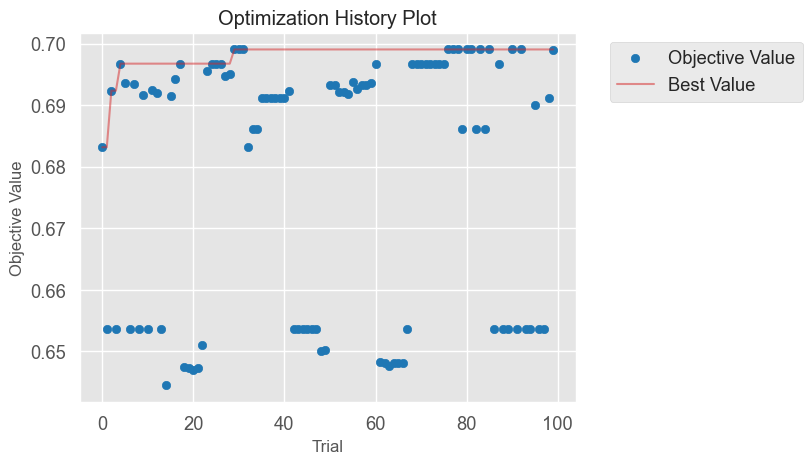

In [32]:
optuna.visualization.matplotlib.plot_optimization_history(study_lr)

In [33]:
# Printing the best parameter outcomes
params_lr = study_lr.best_params
print(params_lr)

{'solver_penalty': ('lbfgs', 'l2'), 'C': 9289.071325982608, 'tol': 0.0050116314978977915, 'verbose': 0}


In [34]:
# Listing the best parameters for modeling
final_params_lr = study_lr.best_trial.params.copy()

In [35]:
# Separating solver and penalty
solver, penalty = final_params_lr.pop('solver_penalty')

# Add them separately
final_params_lr['solver'] = solver
final_params_lr['penalty'] = penalty

In [36]:
# Instantiating the classifier 
model_lr_tuned = LogisticRegression(**final_params_lr, random_state=123)

# Fitting the model
model_lr_tuned.fit(X_train_PSO_full, y_train_full)

LogisticRegression(C=9289.071325982608, random_state=123,
                   tol=0.0050116314978977915)

In [37]:
# Making predictions (test set)
y_pred_lr_tuned = model_lr_tuned.predict(X_test_PSO)
y_proba_lr_tuned = model_lr_tuned.predict_proba(X_test_PSO)
y_proba_lr_tuned_pos = y_proba_lr_tuned[:, 1]

In [38]:
# Making predictions (train set)
y_pred_lr_tuned_train = model_lr_tuned.predict(X_train_PSO_full)
y_proba_lr_tuned_train = model_lr_tuned.predict_proba(X_train_PSO_full)
y_proba_lr_tuned_train_pos = y_proba_lr_tuned_train[:, 1]

#### Evaluating logistic regression

In [39]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_lr_tuned, y_proba_lr_tuned_pos, "logistic regression with PSO feature selection (test set)")

Evaluation metrics for logistic regression with PSO feature selection (test set):
Accuracy: 0.6281
Precision: 0.4016
Recall: 0.7776
F1 Score: 0.5296
AUC-ROC: 0.7284
Precision-Recall AUC: 0.4544


In [40]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_lr_tuned_train, y_proba_lr_tuned_train_pos, "logistic regression with PSO feature selection (train set)")

Evaluation metrics for logistic regression with PSO feature selection (train set):
Accuracy: 0.6671
Precision: 0.6391
Recall: 0.7681
F1 Score: 0.6977
AUC-ROC: 0.7291
Precision-Recall AUC: 0.6928


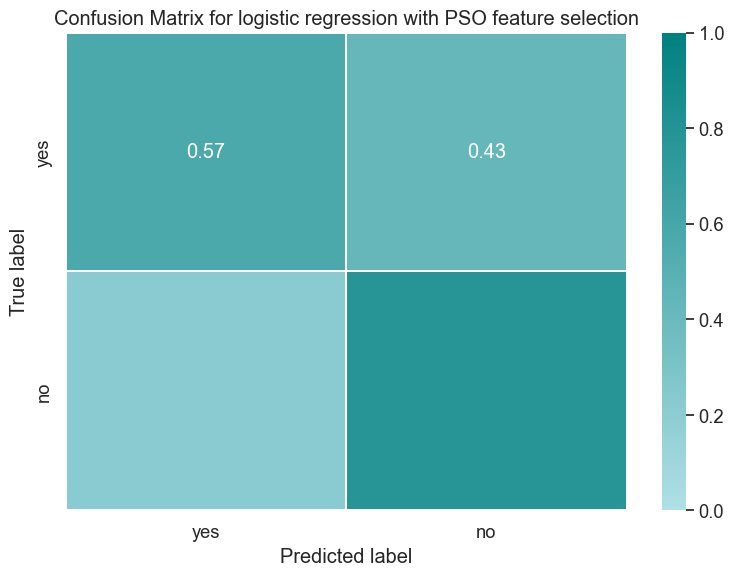

In [41]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr_tuned, "logistic regression with PSO feature selection")

In [42]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr_tuned, target_names = ['yes', 'no']))

              precision    recall  f1-score   support

         yes       0.87      0.57      0.69      5440
          no       0.40      0.78      0.53      2005

    accuracy                           0.63      7445
   macro avg       0.64      0.68      0.61      7445
weighted avg       0.75      0.63      0.65      7445



### Random forest

In [43]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67
# https://www.kaggle.com/code/mustafagerme/optimization-of-random-forest-model-using-optuna

# Define an objective function to be maximized using pre-defined train/val splits
def objective_rf(trial):
    # Defining the hyperparameters to be tuned
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt'])
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    # Defining model with trial hyperparameters
    params_rf = dict(max_depth=max_depth,
                     n_estimators=n_estimators,
                     max_features=max_features,
                     criterion=criterion,
                     min_samples_leaf=min_samples_leaf, 
                     min_samples_split=min_samples_split,
                     bootstrap=bootstrap
                     )
    model_rf = RandomForestClassifier(**params_rf, random_state=123, n_jobs=-1)
    
    # Fitting on training data
    model_rf.fit(X_train_PSO, y_train)
    
    # Predicting and evaluating on validation data
    y_pred = model_rf.predict(X_val_PSO)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_rf.trials))
print('Best parameters:', study_rf.best_trial.params)
print('Best F1 score:', study_rf.best_value)

[I 2025-05-16 19:53:41,189] A new study created in memory with name: no-name-2c9b7c78-56df-448e-843c-1635d09e2382
[I 2025-05-16 19:54:03,190] Trial 5 finished with value: 0.7651342740100137 and parameters: {'n_estimators': 200, 'max_depth': 6, 'max_features': 'log2', 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 5 with value: 0.7651342740100137.
[I 2025-05-16 19:54:18,831] Trial 7 finished with value: 0.77039586919105 and parameters: {'n_estimators': 250, 'max_depth': 7, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_split': 10, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 7 with value: 0.77039586919105.
[I 2025-05-16 19:54:22,703] Trial 3 finished with value: 0.7834691501746216 and parameters: {'n_estimators': 100, 'max_depth': 17, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_split': 5, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 3 with value: 0.7834691501746216.
[I 2

Number of finished trials: 44
Best parameters: {'n_estimators': 400, 'max_depth': 16, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': False}
Best F1 score: 0.7887291280148423


/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_10111/1451018526.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

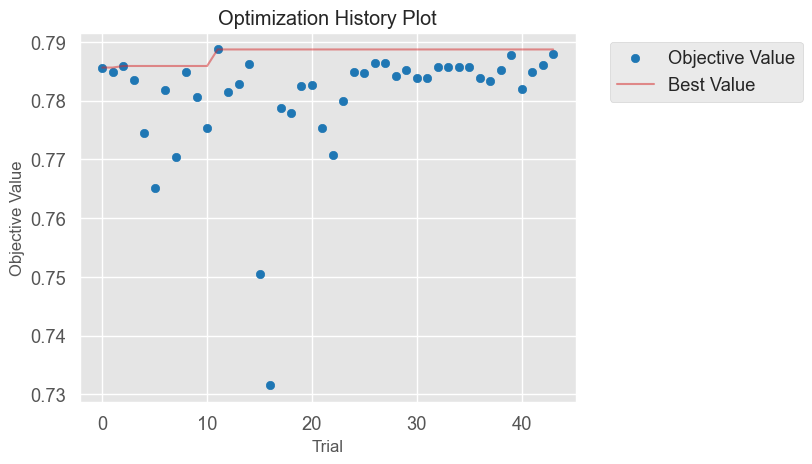

In [44]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

In [45]:
# Printing the best parameter outcomes
params_rf = study_rf.best_params
print(params_rf)

{'n_estimators': 400, 'max_depth': 16, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': False}


In [46]:
# Listing the best parameters for modeling
final_params_rf = dict(max_depth=params_rf['max_depth'],
                       n_estimators=params_rf['n_estimators'],
                       max_features=params_rf['max_features'],
                       criterion=params_rf['criterion'],
                       min_samples_leaf=params_rf['min_samples_leaf'],
                       min_samples_split=params_rf['min_samples_split'],
                       bootstrap=params_rf['bootstrap']
                       )

In [47]:
# Instantiating the classifier 
model_rf_tuned = RandomForestClassifier(**final_params_rf, random_state=123)

# Fitting the model
model_rf_tuned.fit(X_train_PSO_full, y_train_full)

RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=16,
                       min_samples_leaf=10, min_samples_split=3,
                       n_estimators=400, random_state=123)

In [48]:
# Making predictions (test set)
y_pred_rf = model_rf_tuned.predict(X_test_PSO)
y_proba_rf = model_rf_tuned.predict_proba(X_test_PSO)
y_proba_rf_pos = y_proba_rf[:, 1]

In [49]:
# Making predictions (train set)
y_pred_rf_train = model_rf_tuned.predict(X_train_PSO_full)
y_proba_rf_train = model_rf_tuned.predict_proba(X_train_PSO_full)
y_proba_rf_train_pos = y_proba_rf_train[:, 1]

#### Evaluating random forest

In [50]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_rf, y_proba_rf_pos, "random forest with PSO feature selection")

Evaluation metrics for random forest with PSO feature selection:
Accuracy: 0.7678
Precision: 0.5534
Recall: 0.7137
F1 Score: 0.6234
AUC-ROC: 0.8365
Precision-Recall AUC: 0.6280


In [51]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_rf_train, y_proba_rf_train_pos, "random forest with PSO feature selection (train set)")

Evaluation metrics for random forest with PSO feature selection (train set):
Accuracy: 0.9290
Precision: 0.9132
Recall: 0.9483
F1 Score: 0.9304
AUC-ROC: 0.9856
Precision-Recall AUC: 0.9859


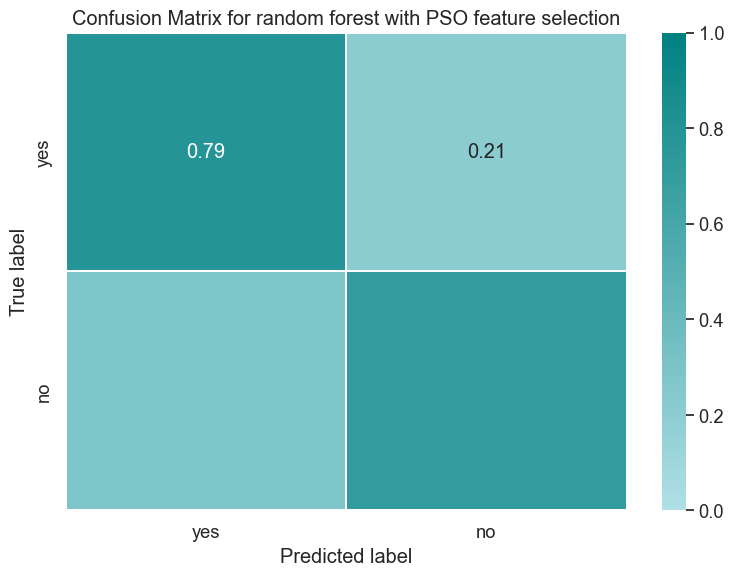

In [52]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, "random forest with PSO feature selection")

In [53]:
# Printing the classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      5440
           1       0.55      0.71      0.62      2005

    accuracy                           0.77      7445
   macro avg       0.72      0.75      0.73      7445
weighted avg       0.79      0.77      0.78      7445



### XGBoost

In [54]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67
# https://www.kaggle.com/code/cahyaalkahfi/xgboost-model-tuning-using-optuna

# Defining an objective function to be maximized using pre-defined train/val splits
def objective_xgb(trial):
    # Defining the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0, 5)
    
    # Defining model with trial hyperparameters
    params_xgb = dict(n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree, 
                     min_child_weight=min_child_weight,
                     gamma=gamma
                     )
    model_xgb = XGBClassifier(**params_xgb, random_state=123, n_jobs=-1)
    
    # Fitting on training data
    model_xgb.fit(X_train_PSO, y_train)
    
    # Predicting and evaluating on validation data
    y_pred = model_xgb.predict(X_val_PSO)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_xgb.trials))
print('Best parameters:', study_xgb.best_trial.params)
print('Best F1 score:', study_xgb.best_value)

[I 2025-05-16 20:06:39,409] A new study created in memory with name: no-name-6982f26f-6f92-4f94-a341-f75418f79d3e
[I 2025-05-16 20:06:40,844] Trial 1 finished with value: 0.8321945570353214 and parameters: {'n_estimators': 88, 'max_depth': 4, 'learning_rate': 0.1631340527664703, 'subsample': 0.7953521675101007, 'colsample_bytree': 0.9336385171614904, 'min_child_weight': 7, 'gamma': 1.161854200887253}. Best is trial 1 with value: 0.8321945570353214.
[I 2025-05-16 20:06:42,008] Trial 4 finished with value: 0.8264754291088643 and parameters: {'n_estimators': 118, 'max_depth': 9, 'learning_rate': 0.14480055589059154, 'subsample': 0.9976218259662252, 'colsample_bytree': 0.9303865303222523, 'min_child_weight': 10, 'gamma': 2.670128124800627}. Best is trial 1 with value: 0.8321945570353214.
[I 2025-05-16 20:06:42,083] Trial 5 finished with value: 0.8319298650363364 and parameters: {'n_estimators': 137, 'max_depth': 4, 'learning_rate': 0.0887408748069531, 'subsample': 0.7788495446938668, 'cols

Number of finished trials: 100
Best parameters: {'n_estimators': 165, 'max_depth': 5, 'learning_rate': 0.10566879042140274, 'subsample': 0.9987543255561139, 'colsample_bytree': 0.9406108550012331, 'min_child_weight': 7, 'gamma': 1.7098167562273652}
Best F1 score: 0.8387776606954689


/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_10111/1860755764.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_xgb)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

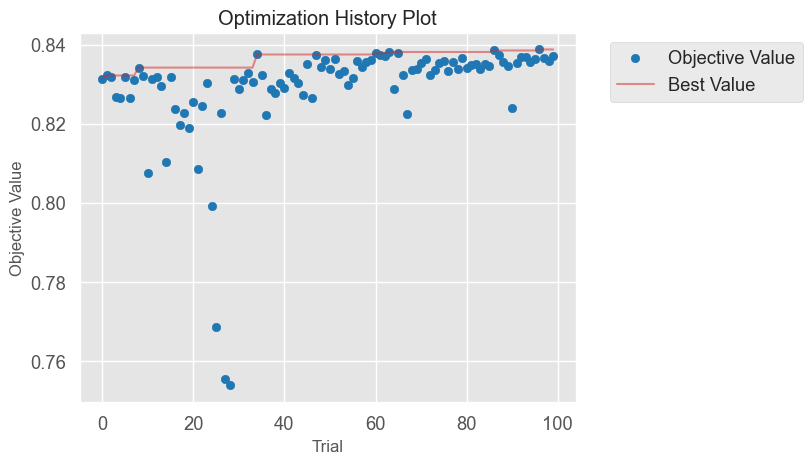

In [55]:
optuna.visualization.matplotlib.plot_optimization_history(study_xgb)

In [56]:
# Printing the best parameter outcomes
params_xgb = study_xgb.best_params
print(params_xgb)

{'n_estimators': 165, 'max_depth': 5, 'learning_rate': 0.10566879042140274, 'subsample': 0.9987543255561139, 'colsample_bytree': 0.9406108550012331, 'min_child_weight': 7, 'gamma': 1.7098167562273652}


In [57]:
# Listing the best parameters for modeling
final_params_xgb = dict(max_depth=params_xgb['max_depth'],
                       learning_rate=params_xgb['learning_rate'],
                       n_estimators=params_xgb['n_estimators'],
                       subsample=params_xgb['subsample'],
                       colsample_bytree=params_xgb['colsample_bytree'],
                       min_child_weight=params_xgb['min_child_weight'],
                       gamma=params_xgb['gamma']
                       )

In [58]:
# Instantiating the classifier 
model_xgb_tuned = XGBClassifier(**final_params_xgb, random_state=123)

# Fitting the model
model_xgb_tuned.fit(X_train_PSO_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9406108550012331, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=1.7098167562273652, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10566879042140274,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=165, n_jobs=None,
              num_parallel_tree=None, ...)

In [59]:
# Making predictions (test set)
y_pred_xgb = model_xgb_tuned.predict(X_test_PSO)
y_proba_xgb = model_xgb_tuned.predict_proba(X_test_PSO)
y_proba_xgb_pos = y_proba_xgb[:, 1]

In [60]:
# Making predictions (train set)
y_pred_xgb_train = model_xgb_tuned.predict(X_train_PSO_full)
y_proba_xgb_train = model_xgb_tuned.predict_proba(X_train_PSO_full)
y_proba_xgb_train_pos = y_proba_xgb_train[:, 1]

#### Evaluating XGBoost

In [61]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_xgb, y_proba_xgb_pos, "XGBoost with PSO feature selection")

Evaluation metrics for XGBoost with PSO feature selection:
Accuracy: 0.7858
Precision: 0.6001
Recall: 0.6130
F1 Score: 0.6065
AUC-ROC: 0.8336
Precision-Recall AUC: 0.6266


In [62]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_xgb_train, y_proba_xgb_train_pos, "XGBoost with PSO feature selection (train set)")

Evaluation metrics for XGBoost with PSO feature selection (train set):
Accuracy: 0.8679
Precision: 0.8743
Recall: 0.8593
F1 Score: 0.8668
AUC-ROC: 0.9479
Precision-Recall AUC: 0.9540


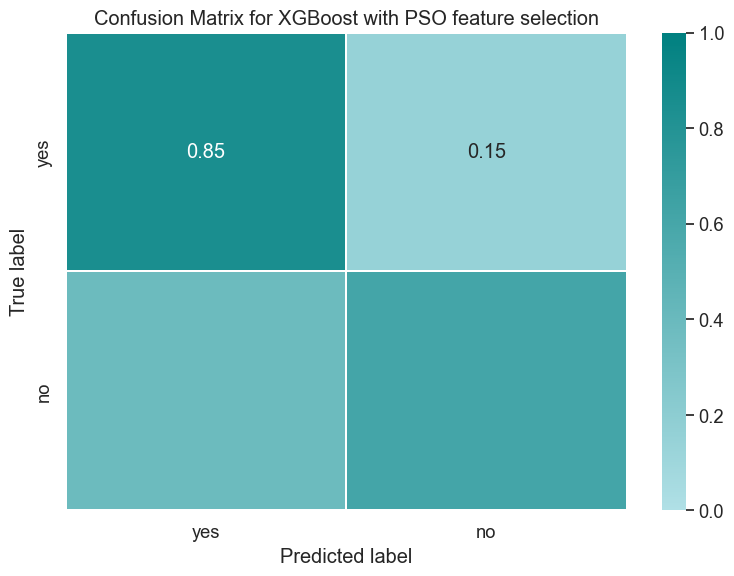

In [63]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost with PSO feature selection")

In [64]:
# Printing the classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5440
           1       0.60      0.61      0.61      2005

    accuracy                           0.79      7445
   macro avg       0.73      0.73      0.73      7445
weighted avg       0.79      0.79      0.79      7445



## SHAP

In [65]:
!pip install shap

In [66]:
import shap

In [67]:
feature_names = X_train_PSO_full.columns.tolist()

In [68]:
X_train_PSO_full = X_train_PSO_full.values.astype(float)

In [69]:
X_train_PSO_full = pd.DataFrame(X_train_PSO_full, columns=feature_names)

### Baseline logistic regression SHAP analysis

In [70]:
# Code inspired by:
# https://github.com/jw-uvt/master-s-thesis-DS-S
# Calculating SHAP values
explainer_baseline_LR = shap.LinearExplainer(model_lr, X_train_PSO_full)
shap_values_baseline_LR = explainer_baseline_LR(X_train_PSO_full)

In [71]:
# Confirming shapes match before plotting
print("shap_values_LR shape:", shap_values_baseline_LR.shape)
print("X_train_PSO_full shape:", X_train_PSO_full.shape)

shap_values_LR shape: (43522, 37)
X_train_PSO_full shape: (43522, 37)


In [72]:
# Ensuring that column names are included
shap_values_baseline_LR_expl = shap.Explanation(
    values=shap_values_baseline_LR,
    base_values=explainer_baseline_LR.expected_value,
    data=X_train_PSO_full,
    feature_names=X_train_PSO_full.columns.tolist()
)

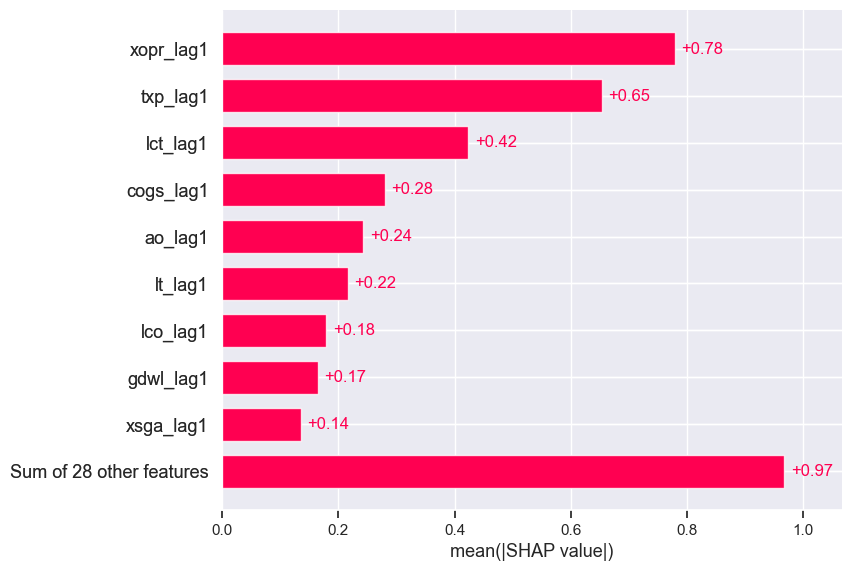

In [73]:
shap.plots.bar(shap_values_baseline_LR_expl)

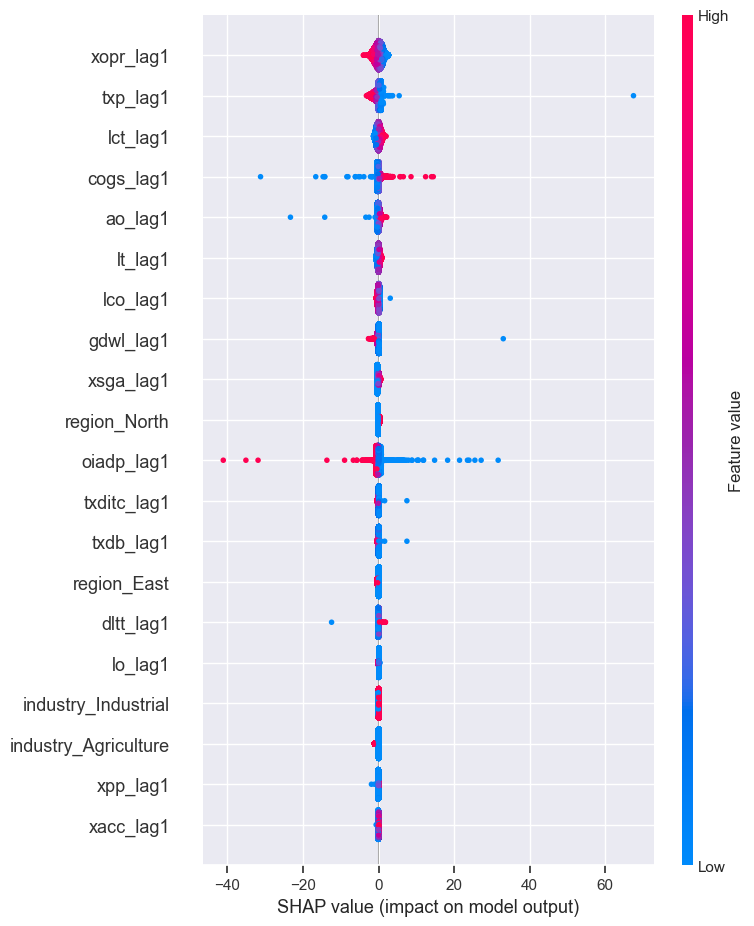

In [74]:
shap_values_baseline_LR_expl = shap_values_baseline_LR_expl.values.astype(float)
shap.summary_plot(shap_values_baseline_LR_expl, X_train_PSO_full, max_display=20)

In [75]:
# Calculating absolute SHAP values
abs_shap_values_LR = np.abs(shap_values_baseline_LR_expl)

# Summing for each feature across all samples
overall_shap_values_baseline_LR = np.sum(shap_values_baseline_LR_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_baseline_LR = np.argsort(overall_shap_values_baseline_LR)[::-1]
sorted_features_baseline_LR = [feature_names[i] for i in sorted_features_indices_baseline_LR]

for feature_LR, shap_value_LR in zip(sorted_features_baseline_LR, overall_shap_values_baseline_LR[sorted_features_indices_baseline_LR]):
    print(f"Feature: {feature_LR}, Overall SHAP Value: {shap_value_LR}")

Feature: txp_lag1, Overall SHAP Value: 2296.5540580554284
Feature: xopr_lag1, Overall SHAP Value: 1656.9603121208813
Feature: lco_lag1, Overall SHAP Value: 1127.4453357505558
Feature: industry_Agriculture, Overall SHAP Value: 389.287258187371
Feature: dltt_lag1, Overall SHAP Value: 263.5156133307336
Feature: ao_lag1, Overall SHAP Value: 132.1812160582692
Feature: capx_lag1, Overall SHAP Value: 121.08236094992034
Feature: txditc_lag1, Overall SHAP Value: 120.32695261624505
Feature: txdb_lag1, Overall SHAP Value: 120.3269526162448
Feature: apo_lag1, Overall SHAP Value: 99.06750436369167
Feature: fyear_sin, Overall SHAP Value: 40.73711272098845
Feature: industry_Social, Overall SHAP Value: 25.34774832873668
Feature: xpp_lag1, Overall SHAP Value: 22.28740623549794
Feature: etr_lag1, Overall SHAP Value: 0.8603582683721773
Feature: fyear_cos, Overall SHAP Value: 0.11423771354111151
Feature: revt_lag1, Overall SHAP Value: -1.590602246053126
Feature: txo_lag1, Overall SHAP Value: -7.7123294589

In [76]:
total_features_baseline_LR = len(sorted_features_baseline_LR)

# Counting number of features with overall SHAP value of 0
zero_shap_count_baseline_LR = np.count_nonzero(overall_shap_values_baseline_LR == 0)

print(f"Total number of features: {total_features_baseline_LR}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_baseline_LR}")

Total number of features: 37
Number of features with overall SHAP value of 0: 0


### Logistic regression SHAP analysis

In [77]:
# Calculating SHAP values
explainer_LR = shap.LinearExplainer(model_lr_tuned, X_train_PSO_full)
shap_values_LR = explainer_LR(X_train_PSO_full)

In [78]:
# Confirming shapes match before plotting
print("shap_values_LR shape:", shap_values_LR.shape)
print("X_train_PSO_full shape:", X_train_PSO_full.shape)

shap_values_LR shape: (43522, 37)
X_train_PSO_full shape: (43522, 37)


In [79]:
# Ensuring that column names are included
shap_values_LR_expl = shap.Explanation(
    values=shap_values_LR,
    base_values=explainer_LR.expected_value,
    data=X_train_PSO_full,
    feature_names=X_train_PSO_full.columns.tolist()
)

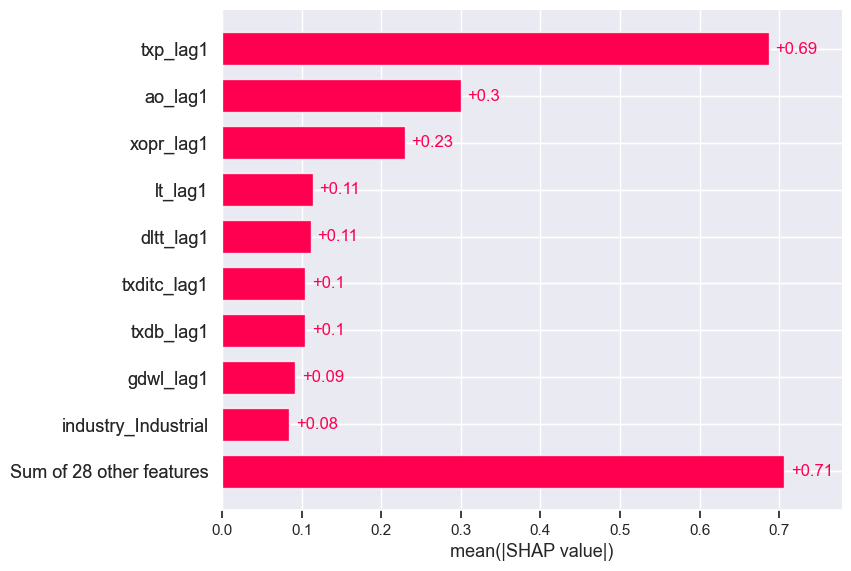

In [80]:
shap.plots.bar(shap_values_LR_expl)

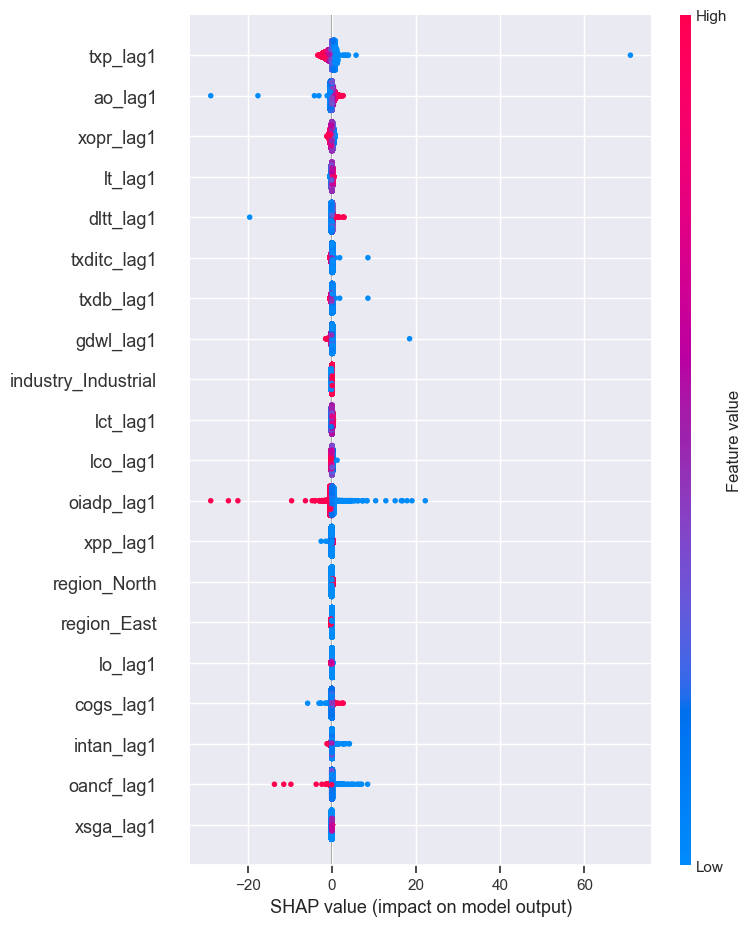

In [81]:
shap_values_LR_expl = shap_values_LR_expl.values.astype(float)
shap.summary_plot(shap_values_LR_expl, X_train_PSO_full, max_display=20)

In [82]:
# Calculating absolute SHAP values
abs_shap_values_LR = np.abs(shap_values_LR_expl)

# Summing for each feature across all samples
overall_shap_values_LR = np.sum(shap_values_LR_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_LR = np.argsort(overall_shap_values_LR)[::-1]
sorted_features_LR = [feature_names[i] for i in sorted_features_indices_LR]

for feature_LR, shap_value_LR in zip(sorted_features_LR, overall_shap_values_LR[sorted_features_indices_LR]):
    print(f"Feature: {feature_LR}, Overall SHAP Value: {shap_value_LR}")

Feature: txp_lag1, Overall SHAP Value: 2414.7220967690964
Feature: xopr_lag1, Overall SHAP Value: 488.18661247879805
Feature: lco_lag1, Overall SHAP Value: 446.8434231413874
Feature: dltt_lag1, Overall SHAP Value: 414.49863854556935
Feature: industry_Services, Overall SHAP Value: 199.64120866374174
Feature: ao_lag1, Overall SHAP Value: 163.30844791520704
Feature: txdb_lag1, Overall SHAP Value: 137.11390330345793
Feature: txditc_lag1, Overall SHAP Value: 137.1139033034579
Feature: apo_lag1, Overall SHAP Value: 110.7137096621437
Feature: capx_lag1, Overall SHAP Value: 65.15202992827214
Feature: industry_Agriculture, Overall SHAP Value: 48.95983550849169
Feature: wcapopc_lag1, Overall SHAP Value: 43.07545949316445
Feature: xpp_lag1, Overall SHAP Value: 30.425922647611895
Feature: fca_lag1, Overall SHAP Value: 3.07008934097117
Feature: etr_lag1, Overall SHAP Value: 2.0444695644603397
Feature: fyear_cos, Overall SHAP Value: 0.1264797520988407
Feature: fyear_sin, Overall SHAP Value: -0.06347

In [83]:
total_features_LR = len(sorted_features_LR)

# Counting number of features with overall SHAP value of 0
zero_shap_count_LR = np.count_nonzero(overall_shap_values_LR == 0)

print(f"Total number of features: {total_features_LR}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_LR}")

Total number of features: 37
Number of features with overall SHAP value of 0: 0


### Random forest SHAP analysis

In [84]:
# Calculating SHAP values
explainer_RF = shap.TreeExplainer(model_rf_tuned, X_train_PSO_full)
shap_values_RF = explainer_RF(X_train_PSO_full, approximate=True)

#### Class 1 (Tax Avoidance)

In [85]:
# Ensuring that column names are included
shap_values_RF_class_1 = shap_values_RF[:, :, 1]
shap_values_RF_expl_1 = shap.Explanation(
    values=shap_values_RF_class_1,
    base_values=explainer_RF.expected_value[1],
    data=X_train_PSO_full,
    feature_names=X_train_PSO_full.columns.tolist()
)

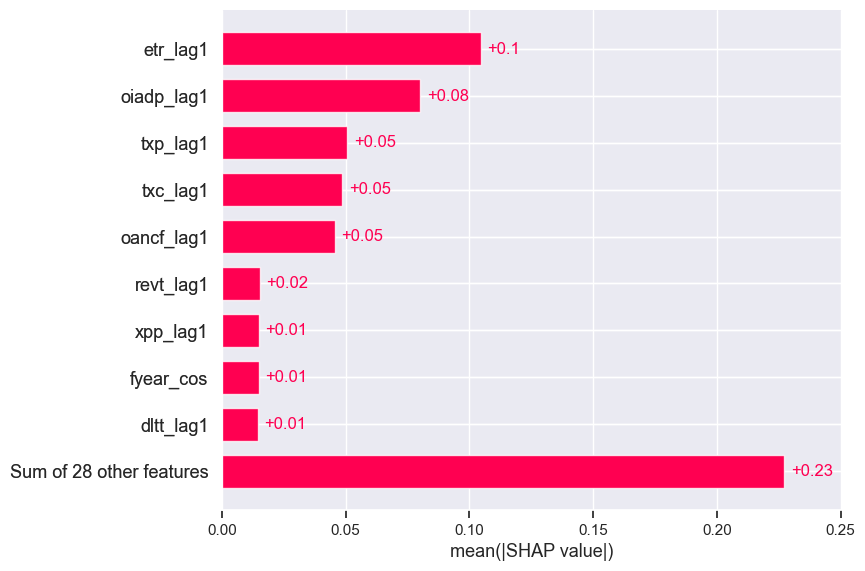

In [86]:
shap.plots.bar(shap_values_RF_expl_1)

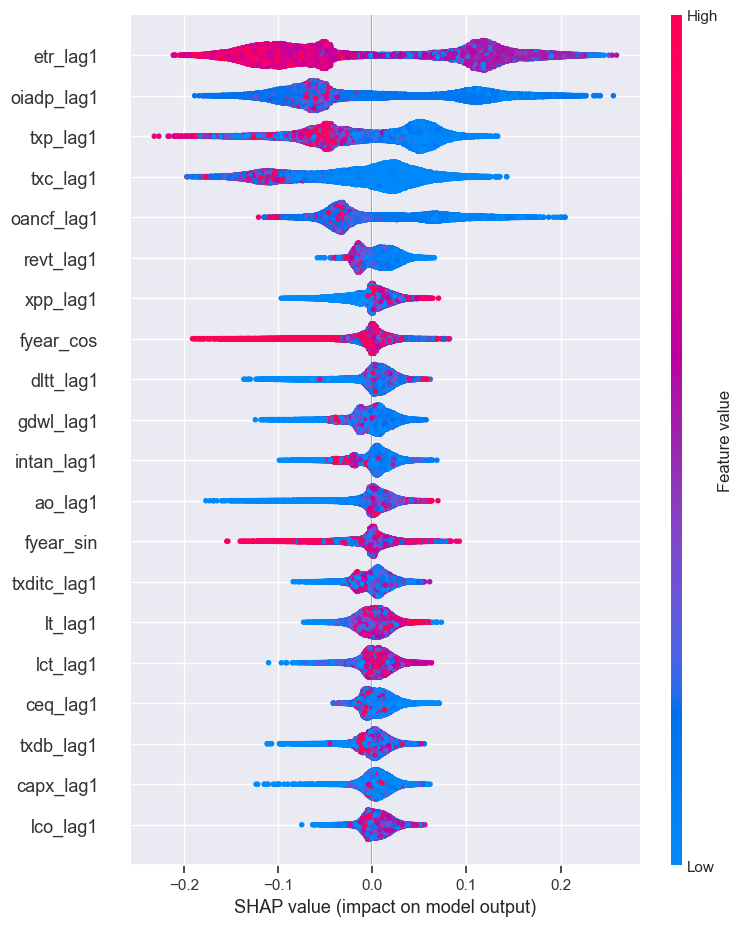

In [87]:
shap_values_RF_array_1 = shap_values_RF_class_1.values.astype(float)
shap.summary_plot(shap_values_RF_array_1, X_train_PSO_full, max_display=20)

In [88]:
# Absolute SHAP values
abs_shap_values_RF_1 = np.abs(shap_values_RF_array_1)

# Overall importance per feature
overall_shap_values_RF_1 = np.sum(abs_shap_values_RF_1, axis=0)

# Sorting features by importance
feature_names = X_train_PSO_full.columns.tolist()
sorted_indices_RF_1 = np.argsort(overall_shap_values_RF_1)[::-1]
sorted_features_RF_1 = [feature_names[i] for i in sorted_indices_RF_1]

# Displaying sorted feature importance
for feature, value in zip(sorted_features_RF_1, overall_shap_values_RF_1[sorted_indices_RF_1]):
    print(f"Feature: {feature}, Overall SHAP Value: {value}")

# Summary stats
total_features_RF_1 = len(sorted_features_RF_1)
zero_shap_count_RF_1 = np.count_nonzero(overall_shap_values_RF_1 == 0)

print(f"Total number of features: {total_features_RF_1}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_RF_1}")

Feature: etr_lag1, Overall SHAP Value: 4555.378450163087
Feature: oiadp_lag1, Overall SHAP Value: 3490.875453645649
Feature: txp_lag1, Overall SHAP Value: 2205.048928037395
Feature: txc_lag1, Overall SHAP Value: 2112.133523844012
Feature: oancf_lag1, Overall SHAP Value: 1982.1289811640083
Feature: revt_lag1, Overall SHAP Value: 663.1950263424308
Feature: xpp_lag1, Overall SHAP Value: 650.6555580187553
Feature: fyear_cos, Overall SHAP Value: 643.6706812171348
Feature: dltt_lag1, Overall SHAP Value: 633.9785892356438
Feature: gdwl_lag1, Overall SHAP Value: 616.8123046231432
Feature: intan_lag1, Overall SHAP Value: 608.0051960889347
Feature: ao_lag1, Overall SHAP Value: 605.6904487115127
Feature: fyear_sin, Overall SHAP Value: 591.737945494496
Feature: txditc_lag1, Overall SHAP Value: 539.4588769111178
Feature: lt_lag1, Overall SHAP Value: 518.9298768486129
Feature: lct_lag1, Overall SHAP Value: 504.8601275887865
Feature: ceq_lag1, Overall SHAP Value: 490.55630465094947
Feature: txdb_lag1

#### Class 0: No Tax Avoidance

In [89]:
# Ensuring that column names are included
shap_values_RF_class_0 = shap_values_RF[:, :, 0]
shap_values_RF_expl_0 = shap.Explanation(
    values=shap_values_RF_class_0,
    base_values=explainer_RF.expected_value[0],
    data=X_train_PSO_full.values,
    feature_names=X_train_PSO_full.columns.tolist()
)

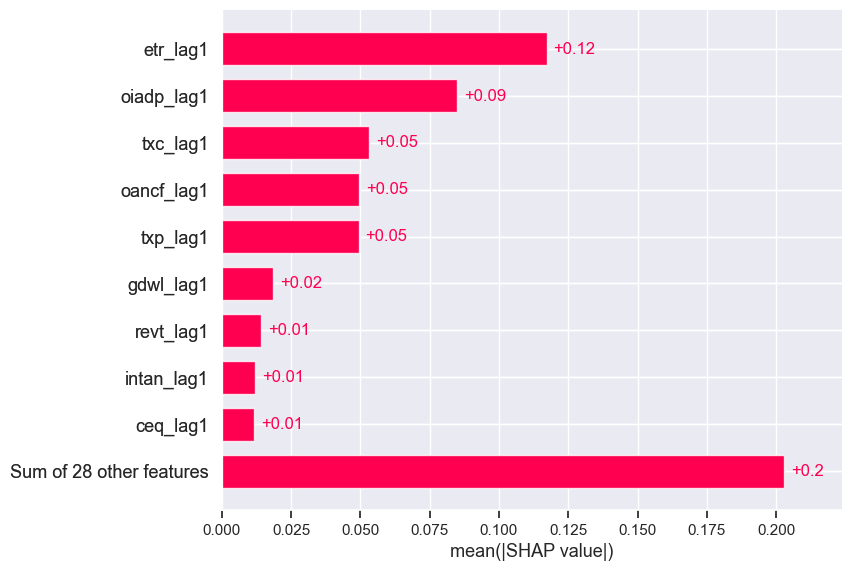

In [90]:
shap.plots.bar(shap_values_RF_expl_0)

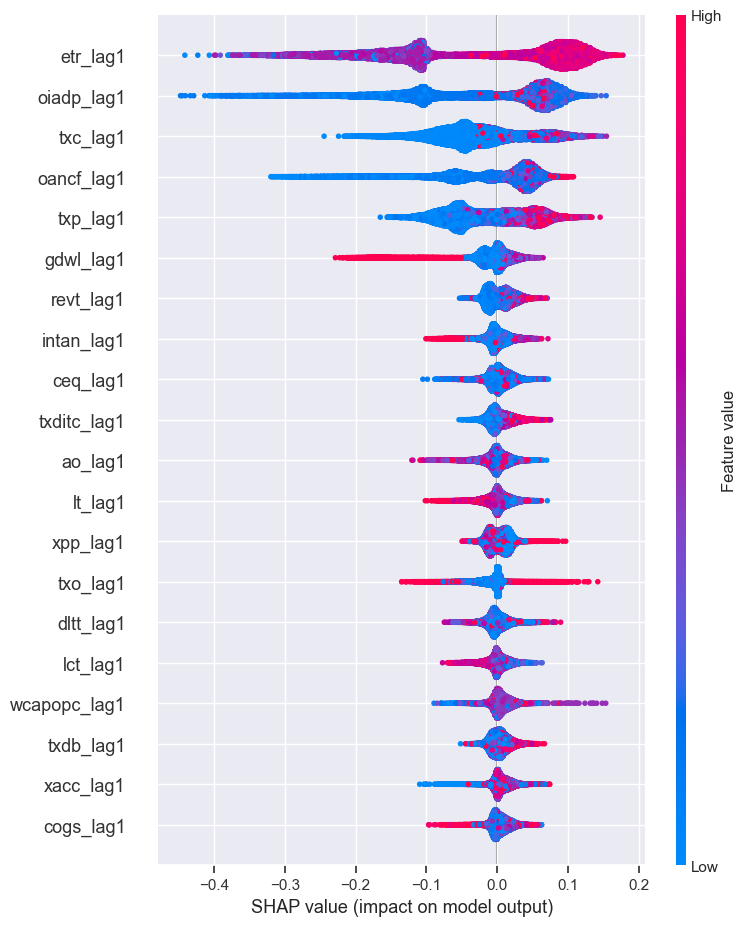

In [91]:
shap_values_RF_array_0 = shap_values_RF_class_0.values.astype(float)
shap.summary_plot(shap_values_RF_array_0, X_train_PSO_full, max_display=20)

In [92]:
# Absolute SHAP values
abs_shap_values_RF_0 = np.abs(shap_values_RF_array_0)

# Overall importance per feature
overall_shap_values_RF_0 = np.sum(abs_shap_values_RF_0, axis=0)

# Sorting features by importance
feature_names = X_train_PSO_full.columns.tolist()
sorted_indices_RF_0 = np.argsort(overall_shap_values_RF_0)[::-1]
sorted_features_RF_0 = [feature_names[i] for i in sorted_indices_RF_0]

# Displaying sorted feature importance
for feature, value in zip(sorted_features_RF_0, overall_shap_values_RF_0[sorted_indices_RF_0]):
    print(f"Feature: {feature}, Overall SHAP Value: {value}")

# Summary stats
total_features_RF_0 = len(sorted_features_RF_0)
zero_shap_count_RF_0 = np.count_nonzero(overall_shap_values_RF_0 == 0)

print(f"Total number of features: {total_features_RF_0}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_RF_0}")

Feature: etr_lag1, Overall SHAP Value: 5105.363732690734
Feature: oiadp_lag1, Overall SHAP Value: 3700.010739467386
Feature: txc_lag1, Overall SHAP Value: 2317.0253635174386
Feature: oancf_lag1, Overall SHAP Value: 2158.1071559095194
Feature: txp_lag1, Overall SHAP Value: 2151.303033870721
Feature: gdwl_lag1, Overall SHAP Value: 804.2963246450414
Feature: revt_lag1, Overall SHAP Value: 617.4536148277018
Feature: intan_lag1, Overall SHAP Value: 522.8634442112608
Feature: ceq_lag1, Overall SHAP Value: 510.38256213264134
Feature: txditc_lag1, Overall SHAP Value: 510.3433758045181
Feature: ao_lag1, Overall SHAP Value: 505.9321302234678
Feature: lt_lag1, Overall SHAP Value: 502.5840250351177
Feature: xpp_lag1, Overall SHAP Value: 499.36773181952543
Feature: txo_lag1, Overall SHAP Value: 465.50773763912156
Feature: dltt_lag1, Overall SHAP Value: 452.74565830634543
Feature: lct_lag1, Overall SHAP Value: 441.2591269186014
Feature: wcapopc_lag1, Overall SHAP Value: 439.5991175485838
Feature: tx

### XGBoost SHAP analysis

In [93]:
# Calculating SHAP values
explainer_XGB = shap.TreeExplainer(model_xgb_tuned, X_train_PSO_full)
shap_values_XGB = explainer_XGB(X_train_PSO_full)

100%|===================| 43448/43522 [02:03<00:00]        

In [94]:
# Confirming shapes match before plotting
print("shap_values_XGB shape:", shap_values_XGB.shape)
print("X_train_PSO_full shape:", X_train_PSO_full.shape)

shap_values_XGB shape: (43522, 37)
X_train_PSO_full shape: (43522, 37)


In [95]:
# Ensuring that column names are included
shap_values_XGB_expl = shap.Explanation(
    values=shap_values_XGB,
    base_values=explainer_XGB.expected_value,
    data=X_train_PSO_full,
    feature_names=X_train_PSO_full.columns.tolist()
)

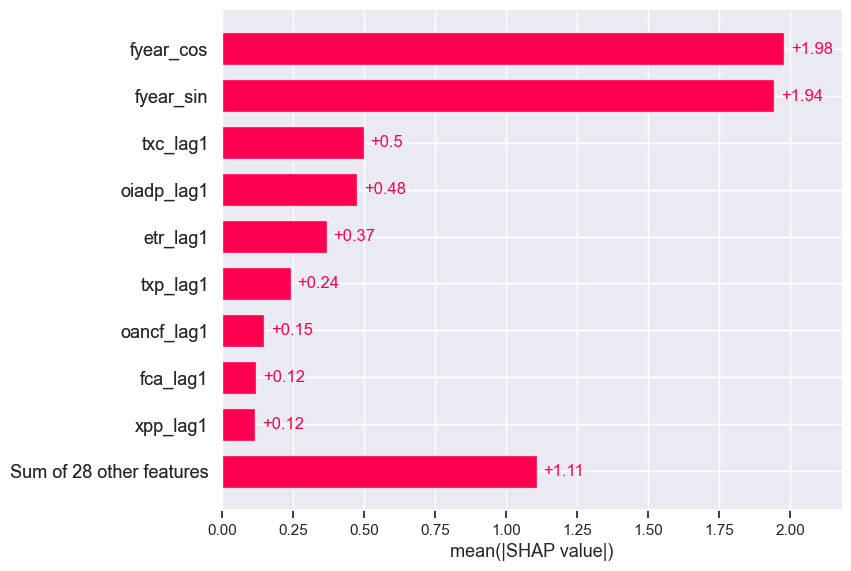

In [96]:
shap.plots.bar(shap_values_XGB_expl)

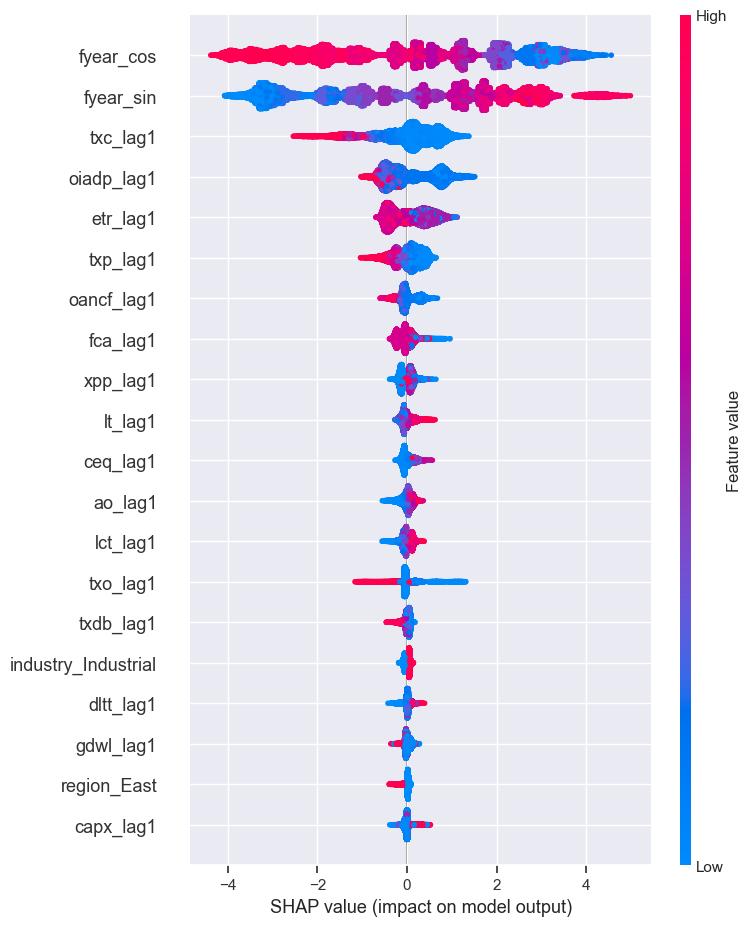

In [97]:
shap_values_XGB_expl = shap_values_XGB_expl.values.astype(float)
shap.summary_plot(shap_values_XGB_expl, X_train_PSO_full, max_display=20)

In [98]:
# Calculating absolute SHAP values
abs_shap_values_XGB = np.abs(shap_values_XGB_expl)

# Summing for each feature across all samples
overall_shap_values_XGB = np.sum(shap_values_XGB_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_XGB = np.argsort(overall_shap_values_XGB)[::-1]
sorted_features_XGB = [feature_names[i] for i in sorted_features_indices_XGB]

for feature_XGB, shap_value_XGB in zip(sorted_features_XGB, overall_shap_values_XGB[sorted_features_indices_XGB]):
    print(f"Feature: {feature_XGB}, Overall SHAP Value: {shap_value_XGB}")

Feature: fyear_cos, Overall SHAP Value: 3198.894354356432
Feature: oiadp_lag1, Overall SHAP Value: 1900.9816995664091
Feature: etr_lag1, Overall SHAP Value: 1836.9280789855186
Feature: txp_lag1, Overall SHAP Value: 1459.7558336822328
Feature: txc_lag1, Overall SHAP Value: 1439.1540502285138
Feature: ceq_lag1, Overall SHAP Value: 612.7047097593659
Feature: dltt_lag1, Overall SHAP Value: 538.4982486681258
Feature: oancf_lag1, Overall SHAP Value: 469.3324731650974
Feature: xsga_lag1, Overall SHAP Value: 463.8216479545418
Feature: gdwl_lag1, Overall SHAP Value: 426.8277411589839
Feature: industry_Services, Overall SHAP Value: 360.58561882146336
Feature: industry_Agriculture, Overall SHAP Value: 258.7378281223028
Feature: xopr_lag1, Overall SHAP Value: 237.83565080304697
Feature: cogs_lag1, Overall SHAP Value: 226.5815934371849
Feature: intan_lag1, Overall SHAP Value: 179.8424580842401
Feature: ao_lag1, Overall SHAP Value: 130.45202408374018
Feature: apo_lag1, Overall SHAP Value: 125.741657

In [99]:
total_features_XGB = len(sorted_features_XGB)

# Counting number of features with overall SHAP value of 0
zero_shap_count_XGB = np.count_nonzero(overall_shap_values_XGB == 0)

print(f"Total number of features: {total_features_XGB}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_XGB}")

Total number of features: 37
Number of features with overall SHAP value of 0: 1
